In [4]:
import zipfile
import os

# Step 1a: Unzip dataset
with zipfile.ZipFile("datasetravdess.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess_folder")  # Extract to a folder

# Step 1b: Check folder structure
os.listdir("ravdess_folder")


['Actor_20',
 'Actor_24',
 'Actor_10',
 'Actor_11',
 'Actor_21',
 'Actor_16',
 'Actor_03',
 'Actor_13',
 'Actor_19',
 'Actor_17',
 'Actor_18',
 'Actor_01',
 'Actor_09',
 'Actor_14',
 'audio_speech_actors_01-24',
 'Actor_05',
 'Actor_23',
 'Actor_08',
 'Actor_06',
 'Actor_04',
 'Actor_12',
 'Actor_15',
 'Actor_02',
 'Actor_07',
 'Actor_22']

In [5]:
# Step 1c: Check files inside one actor folder
os.listdir("ravdess_folder/Actor_01")[:10]  # Show first 10 audio files


['03-01-03-02-01-01-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-03-01-01-01-01.wav',
 '03-01-02-01-02-01-01.wav',
 '03-01-07-01-02-01-01.wav',
 '03-01-06-01-01-01-01.wav',
 '03-01-03-02-02-01-01.wav',
 '03-01-02-02-01-02-01.wav',
 '03-01-03-01-02-02-01.wav',
 '03-01-01-01-02-02-01.wav']

In [6]:
import librosa
import numpy as np

# Function to extract MFCCs from a single audio file
def extract_features(file_path, n_mfcc=40):
    audio, sample_rate = librosa.load(file_path, sr=None)  # Load audio
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)  # Take mean across time axis
    return mfccs_mean

# Step 2a: Prepare dataset
X = []
y = []

# Map emotion codes in file names to labels (RAVDESS convention)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Iterate over all actor folders
dataset_path = "ravdess_folder"
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            X.append(extract_features(file_path))

            # Emotion label is the 3rd group in filename: e.g., '03' -> happy
            emotion_code = file.split("-")[2]
            y.append(emotion_map[emotion_code])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Feature extraction completed!")
print("X shape:", X.shape)
print("y shape:", y.shape)


Feature extraction completed!
X shape: (1440, 40)
y shape: (1440,)


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 3a: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts emotions to numeric labels

# Step 3b: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1152
Testing samples: 288


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv1D, MaxPooling1D, Flatten, Dropout,
                                   LSTM, BatchNormalization, Bidirectional, GlobalAveragePooling1D)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight



def create_improved_model_for_existing_data(input_shape, num_classes):
    """Improved model that works with your existing feature extraction"""

    model = Sequential([
        # Enhanced Conv blocks
        Conv1D(128, 5, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(512, 3, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        # Bidirectional LSTM
        Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),

        # Dense layers with regularization
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])

    return model


model = create_improved_model_for_existing_data((X_train.shape[1], 1), num_classes)

# Enhanced compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Add callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
]

# Train with callbacks
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 313ms/step - accuracy: 0.1285 - loss: 4.3347 - precision: 0.1374 - recall: 0.0657 - val_accuracy: 0.1319 - val_loss: 3.3017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.1432 - loss: 4.1113 - precision: 0.1655 - recall: 0.0716 - val_accuracy: 0.1319 - val_loss: 3.2766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.2093 - loss: 3.8245 - precision: 0.2467 - recall: 0.0895 - val_accuracy: 0.1771 - val_loss: 3.2678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.1643 - loss: 3.7769 - precision: 0.2097 - recall: 0.0747 - val_accuracy: 0.1389 - val_loss: 3.3294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/150
36/36 ━━━━━━━

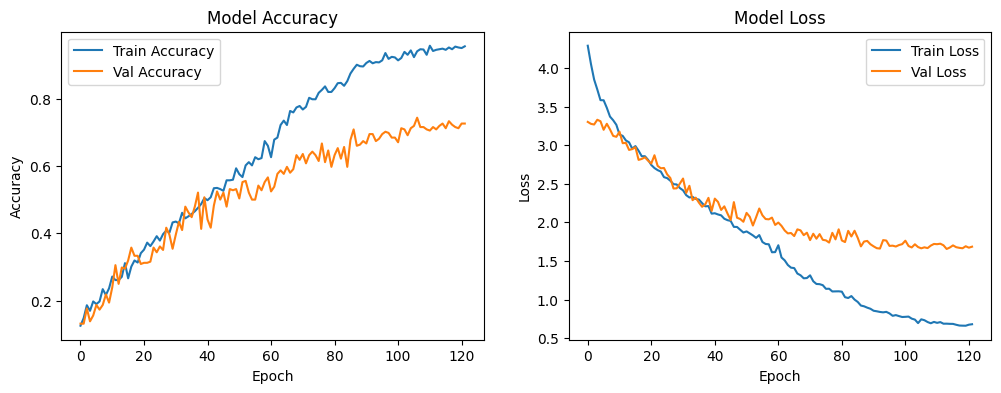

In [14]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


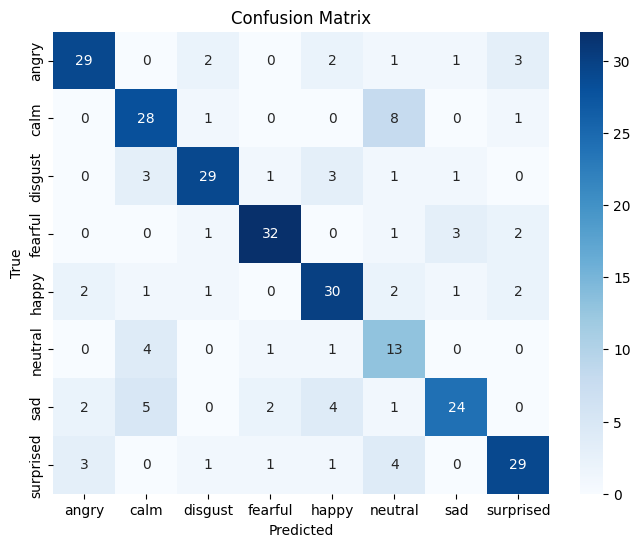

              precision    recall  f1-score   support

       angry       0.81      0.76      0.78        38
        calm       0.68      0.74      0.71        38
     disgust       0.83      0.76      0.79        38
     fearful       0.86      0.82      0.84        39
       happy       0.73      0.77      0.75        39
     neutral       0.42      0.68      0.52        19
         sad       0.80      0.63      0.71        38
   surprised       0.78      0.74      0.76        39

    accuracy                           0.74       288
   macro avg       0.74      0.74      0.73       288
weighted avg       0.76      0.74      0.75       288



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))


In [16]:
# Save the full model (architecture + weights + optimizer)
model.save("speech_emotion_model.h5")
print("Model saved as speech_emotion_model.h5")


Model saved as speech_emotion_model.h5


In [17]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("speech_emotion_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [19]:
# Predicted emotion
y_new_prob = loaded_model.predict(X_test[:1])
y_new_pred = np.argmax(y_new_prob, axis=1)
predicted_emotion = le.classes_[y_new_pred[0]]

# Actual emotion
actual_emotion = le.classes_[y_test[0]]

print("Predicted emotion:", predicted_emotion)
print("Actual emotion:   ", actual_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicted emotion: sad
Actual emotion:    sad
